### 📚 가중 무작위 샘플링

#### 💡 가중치 함수 만들기

In [5]:
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [25]:
import numpy as np
def make_weights(labels, nclasses) :
    # 리스트를 넘파이 배열로 바꾼다. 
    labels = np.array(labels)
    weight_list = []
    
    # 각 클래스마다 라벨의 개수를 센다.
    for cls in range(nclasses) :
        idx = np.where(labels == cls)[0]
        count = len(idx)
        
        # 라벨이 뽑힐 가중치를 1/count로 동일하게 해당 라벨 전체에 할당
        weight = 1/count
        # 개수만큼 만들기
        weights = [weight]*count
        # 데이터를 불러올 때 ImageFolder를 사용할 경우 라벨이 0부터 N까지 나열되어 있기 때문에 각 클래스의 가중치를 일렬로 이어주기
        weight_list += weights
    return weight_list

#### 💡 이미지 데이터 불러오기

In [26]:
transf = tr.Compose([tr.Resize((16, 16)),
                     tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf)

#### 💡 가중치 생성하기

In [27]:
# 가중치 생성 후 텐서로 변환
# 각 클래스의 가중치는 같다. 
weights = make_weights(trainset.targets, len(trainset.classes))
weights = torch.DoubleTensor(weights)
print(weights)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714],
       dtype=torch.float64)


#### 💡 데이터 로더 생성하기

- `WeightedRandomSampler` : 배치를 불러올 때 자동으로 클래스에 대한 균일 분포를 갖는 배치를 만들 수 있다. (데이터로더에 추가)

In [32]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
# 가중 무작위 샘플링
trainloader_wrs = DataLoader(trainset, batch_size=6, sampler=sampler)
# 무작위 샘플링
trainloader_rs = DataLoader(trainset, batch_size=6, shuffle=True)

#### 💡 가중 무작위 샘플링 vs 무작위 샘플링

In [29]:
for epoch in range(5) :
    for data in trainloader_wrs :
        print(data[1])

tensor([1, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 0, 1, 1])
tensor([0, 0, 1, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([1, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 1])


In [34]:
# 1이 대부분으로 뽑힌다.
for epoch in range(5) :
    for data in trainloader_rs :
        print(data[1])

tensor([1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 0, 1, 1])
tensor([0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 1])


--------------------------------------------------------------------------------------

### 📚 가중 손실 함수

- `nn.CrossEntropyLoss` : 가중 손실 함수를 제공하므로, 미리 정의된 weights를 입력하면 쉽게 구현 가능

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 10개의 클래스 별 이미지 개수
# 가중 손실 함수는 데이터가 적은 클래스에 대해서 큰 가중치를 부여함으로써 업데이트 균형을 맞추려는 의도
num_ins = [40, 45, 30, 62, 70, 153, 395, 46, 75, 194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

--------------------------------------------------------------------------------------

### 📚 혼동 행렬

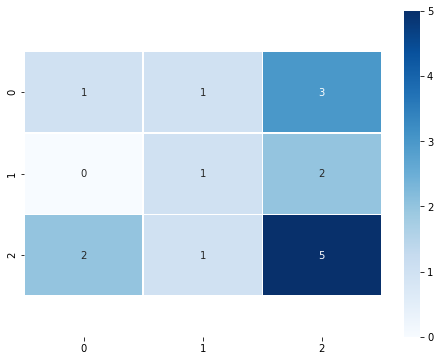

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
actual = [1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]
prediction = [1, 2, 2, 0, 2, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2]
c_mat = confusion_matrix(actual, prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues', linewidth=.5)

# plt.yplim()을 그냥 사용할 경우 버전에 따라 위 아래가 잘려서 그래프가 출력될 수 있으므로 위아래 볌위를 0.5씩 확보
b, t = plt.ylim()
b += 0.5
t -= 0.5

plt.ylim(b, t)
plt.savefig('confusion_matrix.png')
plt.show()